# Store Sales - Time Series Forecasting
#### エクアドルに拠点を置く大手食料品小売企業のデータから、時系列予測を使って店舗の売上を予測する。

評価指標は、RMSLE(Root Mean Squared Logarithmic Error（平均二乗対数誤差）)

ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np

import pycaret

#setup関数をimport
from pycaret.regression import setup

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
from pycaret.regression import finalize_model

from pycaret.regression import predict_model

import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
import lightgbm as lgb
import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

from datetime import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns

trainデータの読み込み

trainデータ  
1. id
2. date
3. store_nbr:商品が販売されている店舗No    
4. family:販売されている商品の種類  
5. sales:行の日付,商品の総売り上げ  
※製品は端数単位で販売されることがあるため、端数の値も可能（たとえば、1袋のチップスではなく、1.5 kgのチーズ）
6. onpromotion:店舗でプロモーションが行われた商品群の総数

In [7]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
train_df.shape

(3000888, 6)

In [10]:
train_df['sales'].value_counts()

0.000       939130
1.000       115291
2.000        85959
3.000        68575
4.000        57846
             ...  
116.541          1
363.533          1
141.322          1
409.879          1
2419.729         1
Name: sales, Length: 379610, dtype: int64

In [13]:
train_df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
train_df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


testデータ  
* 日付、商品ごとの総売り上げを予測する。  
* trainデータの最後のデータから次の日のデータになっている。
* 

In [11]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [17]:
test_df.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


In [68]:
test_df.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [12]:
test_df.shape

(28512, 5)

trainデータとtestデータにそんなに差は無さそう。

In [63]:
#train_dfとtest_dfを結合する。
df = pd.concat([train_df, test_df], axis=0)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [65]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.029400e+06,3.029400e+06,3.000888e+06,3.029400e+06
mean,1.514700e+06,2.750000e+01,3.577757e+02,2.643830e+00
std,8.745126e+05,1.558579e+01,1.101998e+03,1.233287e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.573498e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.514700e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.272049e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.029399e+06,5.400000e+01,1.247170e+05,7.410000e+02


特に外れ値などは無さそう。

storesデータ  
1. city:店舗がある都市  
2. state:店舗がある州  
3. type:  
4. cluster: 類似した店舗のグループ化   
typeとclusterを教師なし学習などで分類して正体を見ておく必要あり。

In [14]:
stores_df = pd.read_csv('stores.csv')
stores_df.head() 

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


oilデータ  
train_dfとtest_dfの日付と対応するデータがある  
→train_df用とtest_df用にわけて結合する必要あり。
dcoilwtico:各日付の原油価格  
※エクアドルは石油に依存する国であり、石油価格の変動に対して非常に脆弱な経済状態である  
→原油価格が高い日は、価格が向上し、購買意欲も低くなる傾向があるのでは、

In [15]:
oil_df = pd.read_csv('oil.csv')
oil_df.head() 

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [16]:
oil_df.tail() 

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [19]:
oil_df.shape

(1218, 2)

holidays_eventsデータ  
Additional holidays:クリスマス前後のような通常カレンダーに追加された休日  
locale_name:エクアドルの町名、地域名を示している。  
description:locale_nameの詳細  
trainsfereed:Trueの日は別の日がかわりに休日になっているので、Trueの日は平日と考えてよい。
このデータは

In [56]:
holidays_events_df = pd.read_csv('holidays_events.csv')
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [30]:
holidays_events_df.shape

(350, 6)

In [28]:
holidays_events_df['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [29]:
holidays_events_df['transferred'].value_counts()

False    338
True      12
Name: transferred, dtype: int64

In [54]:
holidays_events_df.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

In [53]:
holidays_events_df[holidays_events_df['transferred'].isin(['True'])]

,date,type,locale,locale_name,description,transferred


In [52]:
#'transferred'のTureデータの確認
holidays_events_df[holidays_events_df['locale_name'].isin(['Manta'])]

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
46,2013-03-02,Holiday,Local,Manta,Fundacion de Manta,False
93,2014-03-02,Holiday,Local,Manta,Fundacion de Manta,False
164,2015-03-02,Holiday,Local,Manta,Fundacion de Manta,False
214,2016-03-02,Holiday,Local,Manta,Fundacion de Manta,False
301,2017-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [31]:
holidays_events_df['locale_name'].value_counts()

Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: locale_name, dtype: int64

transactionsデータ  
store_nbr:商品No  
trainsactions:取引数

In [21]:
transactions_df = pd.read_csv('transactions.csv')
transactions_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


sample_submissionのデータ読み込み

In [66]:
sample_submission_df = pd.read_csv('sample_submission.csv')
sample_submission_df.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


補足情報  
* 毎月15日と月末に資金が支払われる。そのためスーパーマーケットの売上に影響する可能性。  
* 2016年4月16日、エクアドルでマグニチュード7.8の地震が発生しました。地震発生後数週間はスーパーマーケットの売上に大きな影響を与えたため、人々は水やその他の生活必需品を寄付する救援活動を行っている。

### 時系列データとして扱うための前処理

In [70]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [8]:
#売上日の列を日時型に変換して置き換え
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [9]:
#'date'列をインデックスに入れる。
train_df = train_df.set_index('date')
train_df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


### 期間ごとのデータ集計

In [13]:
#売上日と売上金額のデータフレームを作成
train_sales_df = train_df[['sales']]
train_sales_df.head()

,sales
date,
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0


In [ ]:
#pd.reset_option('display.precision')

In [116]:
pd.options.display.precision = 2

pd.options.display.float_format


In [145]:
#月ごとの合計、平均、最大値、最小値
train_sales_df.resample('M').agg(['sum','mean','max','min']).head()

sales                      
                 sum    mean      max  min
date                                      
2013-01-31  1.03e+07  186.95  19849.0  0.0
2013-02-28  9.66e+06  193.58  26067.0  0.0
2013-03-31  1.14e+07  206.88  14075.0  0.0
2013-04-30  1.10e+07  205.64  15836.0  0.0
2013-05-31  1.16e+07  209.94  13874.0  0.0

In [141]:
#四半期ごとの合計、平均、最大値、最小値
train_sales_df.resample('Q').agg(['sum','mean','max','min']).head()

sales                      
                 sum    mean      max  min
date                                      
2013-03-31  3.14e+07  195.88  26067.0  0.0
2013-06-30  3.43e+07  211.40  15836.0  0.0
2013-09-30  3.48e+07  212.20  16105.0  0.0
2013-12-31  3.99e+07  246.27  46271.0  0.0
2014-03-31  5.13e+07  319.96  18192.0  0.0

In [139]:
#年ごとの合計、平均、最大値、最小値
train_sales_df.resample('Y').agg(['sum','mean','max','min']).head()

sales                        
                 sum    mean        max  min
date                                        
2013-12-31  1.40e+08  216.48   46271.00  0.0
2014-12-31  2.09e+08  322.94   45361.00  0.0
2015-12-31  2.41e+08  371.36   40351.46  0.0
2016-12-31  2.89e+08  443.79  124717.00  0.0
2017-12-31  1.94e+08  480.12   38422.62  0.0

2016年の4月に大地震が起きているが、年単位で見るとさほど影響はないように見える。
月、四半期単位でみると2016年4月,5月にmaxが大きいものがある。

### 曜日ごとの集計

,sales
date,
2013-01-01,0.00
2013-01-01,0.00
2013-01-01,0.00
2013-01-01,0.00
2013-01-01,0.00
...,...
2017-08-15,438.13
2017-08-15,154.55
2017-08-15,2419.73


In [130]:
train_sales_df.index.weekday

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='date', length=3000888)

In [131]:
#月曜日のみのデータを抽出する。
train_sales_df[train_sales_df.index.weekday == 0]

,sales
date,
2013-01-07,0.00
2013-01-07,0.00
2013-01-07,1.00
2013-01-07,1158.00
2013-01-07,0.00
...,...
2017-08-14,283.43
2017-08-14,114.12
2017-08-14,1348.42


In [132]:
#月曜日のみの売上データの平均を抽出する。
train_sales_df[train_sales_df.index.weekday == 0].mean()

sales    346.54
dtype: float64

In [147]:
#曜日ごとの売上金額の合計を表示
train_sales_week_df = train_sales_df.set_index(train_sales_df.index.weekday)

#index名を曜日番号に変更
train_sales_week_df.index.name = '曜日番号'

#各曜日の合計を表示
train_sales_week_df.sum(level='曜日番号').sort_index()

,sales
曜日番号,
0,1.49e+08
1,1.38e+08
2,1.42e+08
3,1.21e+08
4,1.39e+08
5,1.86e+08
6,1.98e+08


In [135]:
#各曜日の平均を表示
train_sales_week_df.mean(level='曜日番号').sort_index()

,sales
曜日番号,
0,346.54
1,319.82
2,332.91
3,283.54
4,325.24
5,433.34
6,463.09


やはり5,6の土曜、日曜の売上は高い傾向にある。

In [149]:
train_sales_week_df.head()

,sales
曜日番号,
1,0.0
1,0.0
1,0.0
1,0.0
1,0.0


In [151]:
train_df.shape,train_sales_week_df.shape

((3000888, 5), (3000888, 1))

In [152]:
#trainデータに曜日列を加える。
train_df['曜日'] = train_df.index.strftime('%A')
train_df.head()

,id,store_nbr,family,sales,onpromotion,曜日
date,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,Tuesday


#### 折れ線グラフ

In [10]:
#trainデータからidと曜日を一旦抜く。
train_df = train_df[['store_nbr','family','onpromotion','sales']]

In [11]:
train_df.head()

,store_nbr,family,onpromotion,sales
date,,,,
2013-01-01,1,AUTOMOTIVE,0,0.0
2013-01-01,1,BABY CARE,0,0.0
2013-01-01,1,BEAUTY,0,0.0
2013-01-01,1,BEVERAGES,0,0.0
2013-01-01,1,BOOKS,0,0.0


<AxesSubplot:xlabel='date'>

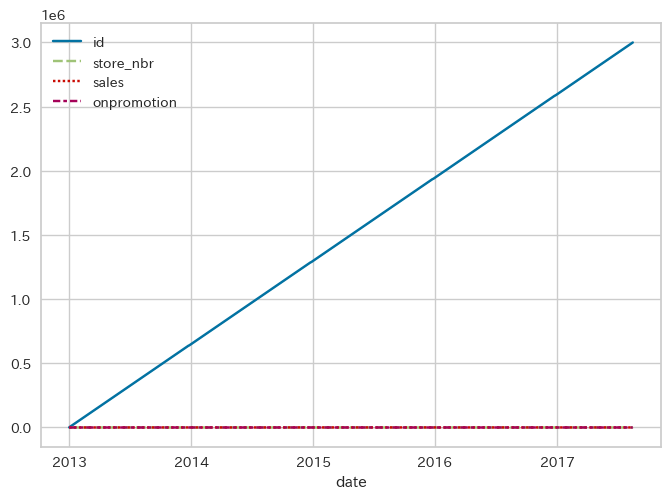

In [155]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#全ての年代を表示 
sns.lineplot(data=train_df)

年月の幅がひろすぎて、参考にならない。

<AxesSubplot:xlabel='date'>

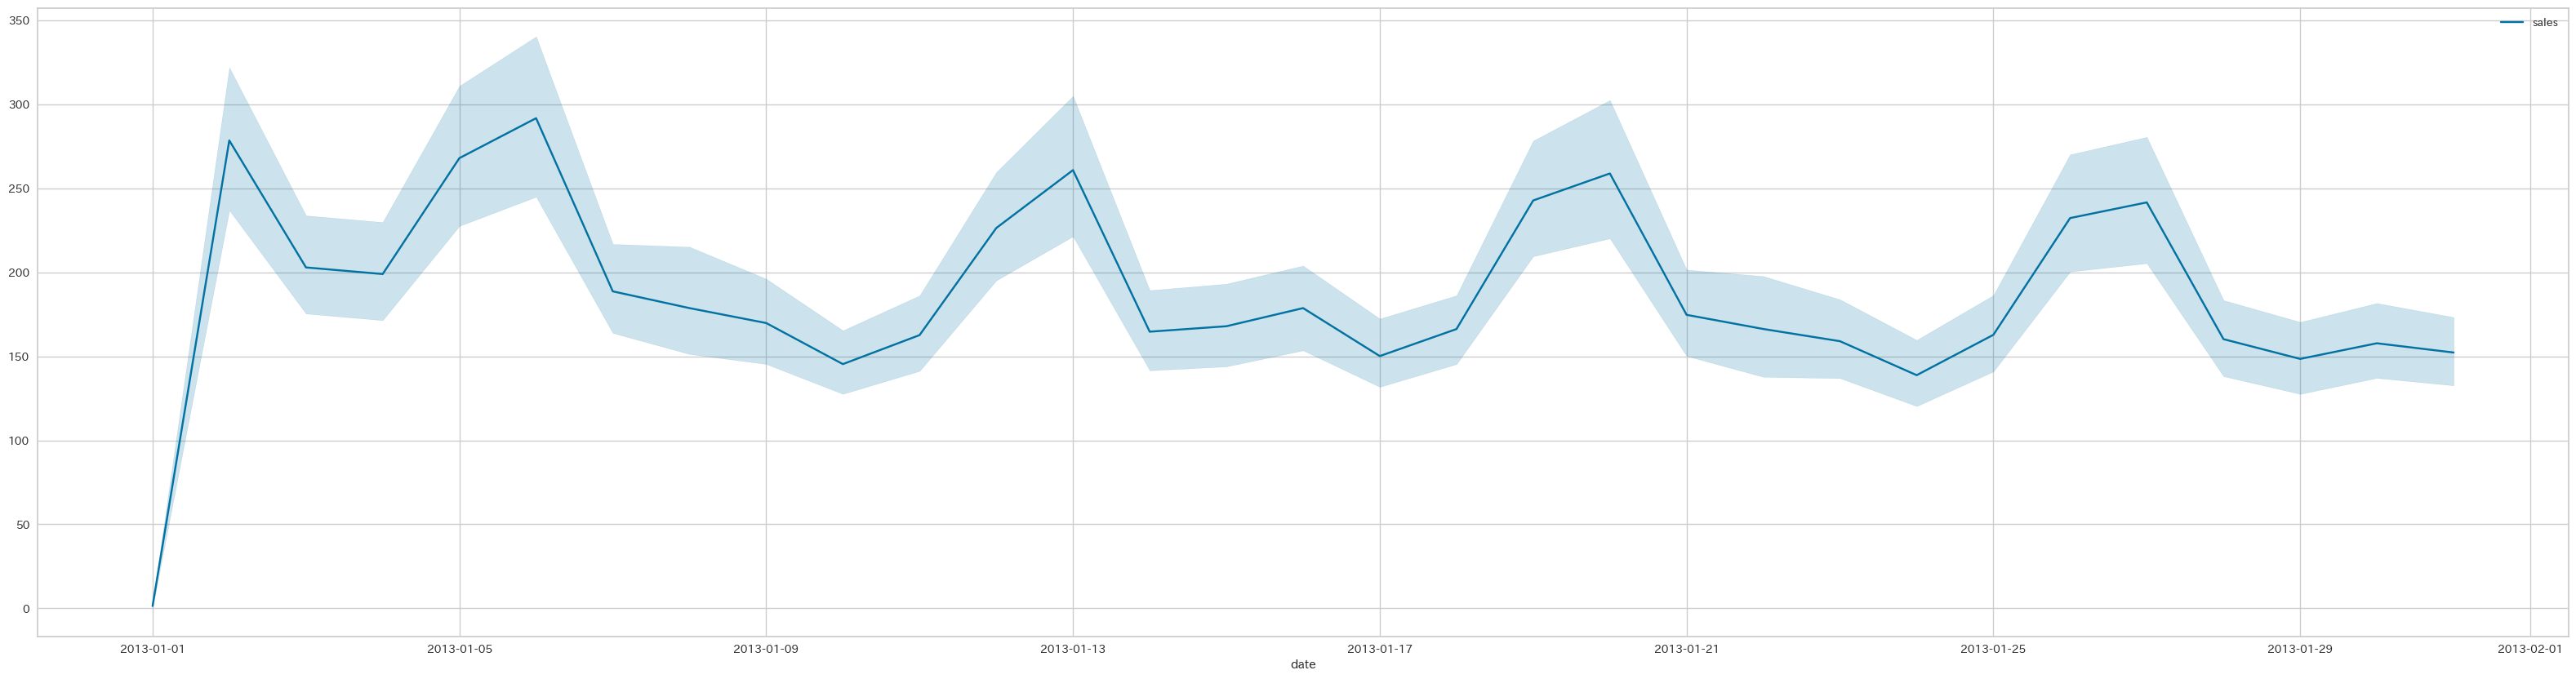

In [15]:
#2013-01を表示 
fig = plt.subplots(figsize=(40,10))
sns.lineplot(data=train_sales_df['2013-01'])

<AxesSubplot:xlabel='date'>

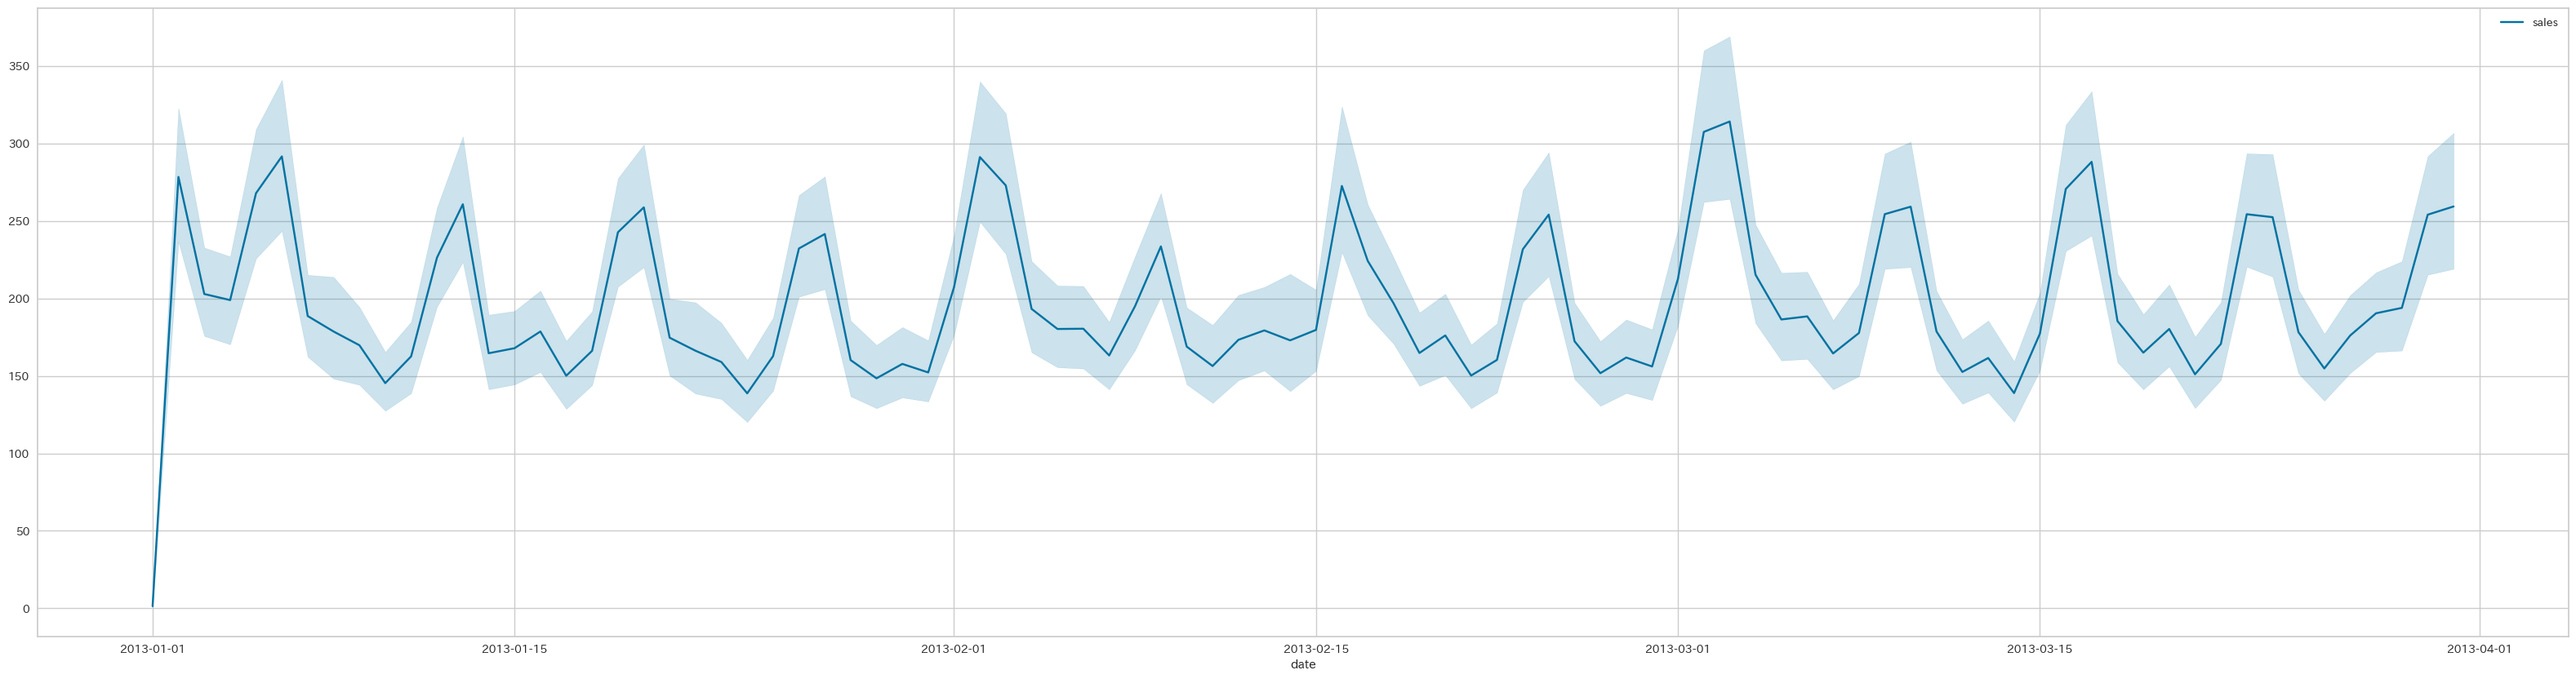

In [17]:
#2013-01~2013-03を表示 
fig = plt.subplots(figsize=(40,10))
sns.lineplot(data=train_sales_df['2013-01':'2013-03'])

<AxesSubplot:xlabel='date'>

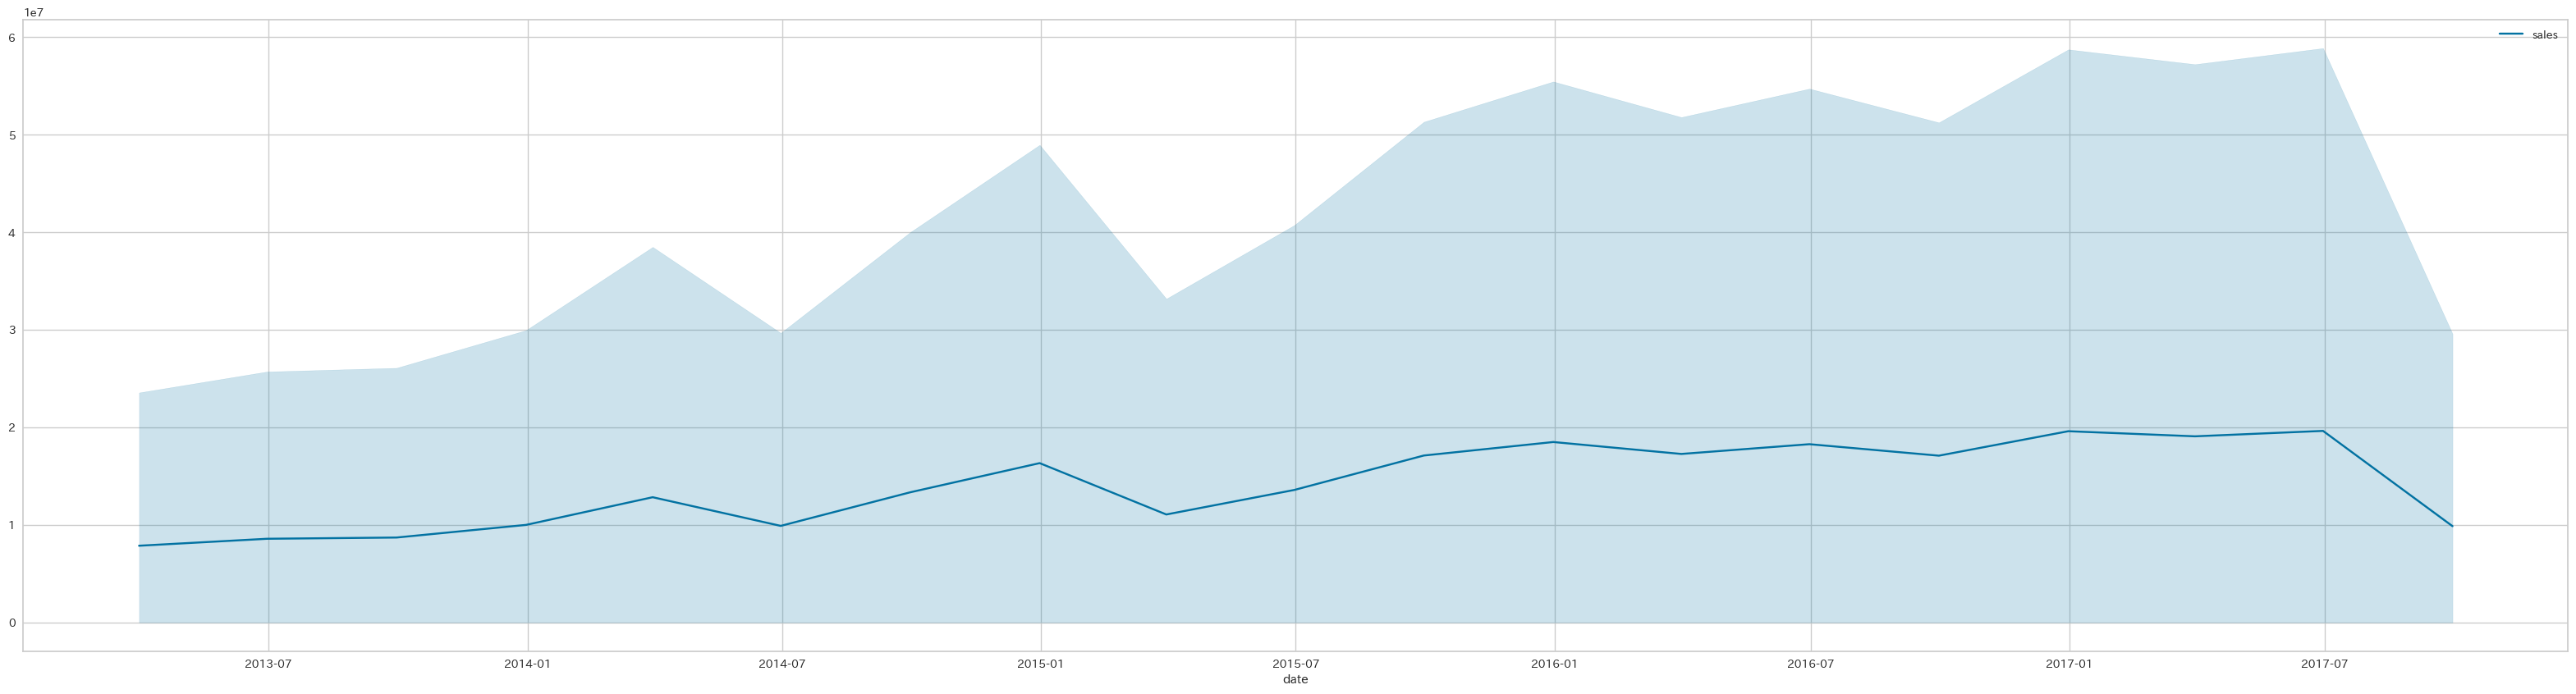

In [19]:
#四半期ごとの平均、合計、最大、最低値を表示 
fig = plt.subplots(figsize=(40,10))
sns.lineplot(data=train_sales_df.resample('Q').agg(['sum','mean','max','min']))

<AxesSubplot:xlabel='date'>

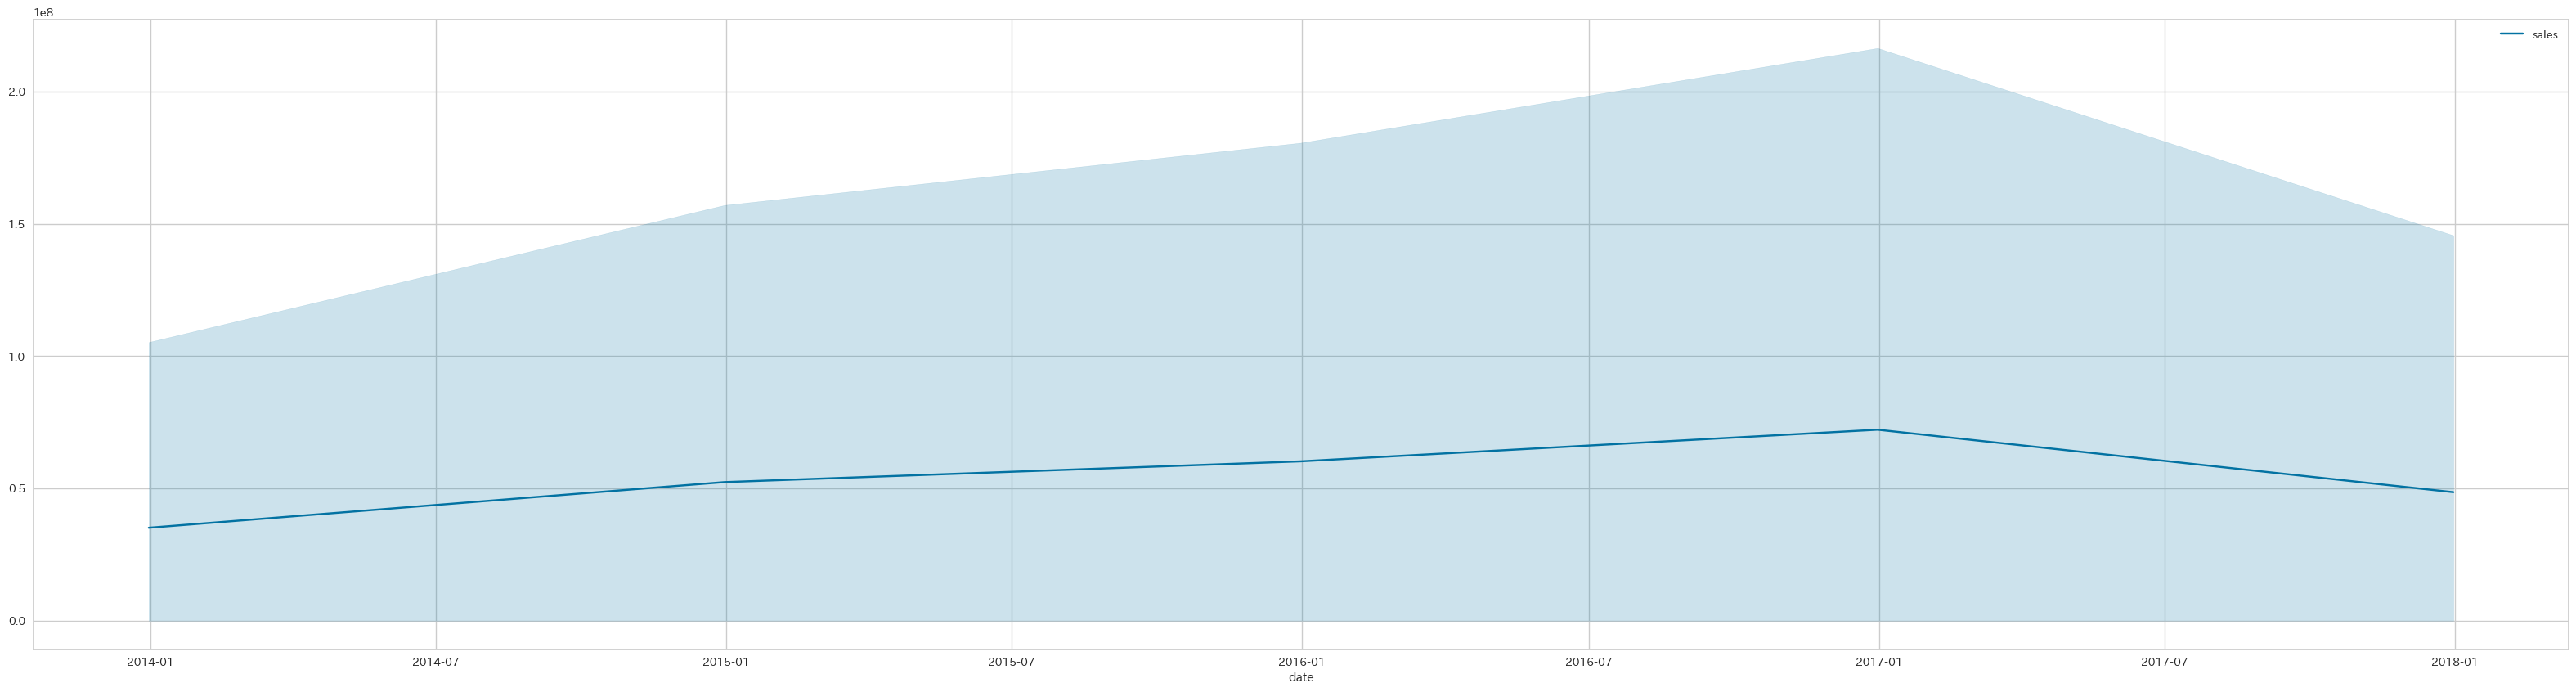

In [20]:
#年ごとの平均、合計、最大、最低値を表示 
fig = plt.subplots(figsize=(40,10))
sns.lineplot(data=train_sales_df.resample('Y').agg(['sum','mean','max','min']))

長期で見るとほとんど、変化はない。

#### 差分のデータを生成する。

In [30]:
#前日差をのsalesデータを作る。
train_sales_df['sales_前日差'] = train_sales_df['sales'].diff(-1)

#前日との変化率
train_sales_df['sales_前日変化率'] = train_sales_df['sales'].pct_change(-1)  #.map('{:.1%}'.format)

#前日とのずらし
train_sales_df['sales_前日ずらし'] = train_sales_df['sales'].shift()

#1週間の移動平均
train_sales_df['sales_1週間移動平均'] = train_sales_df['sales'].rolling(7.min_periods=1).mean()

train_sales_df.head()

,sales,sales_前日差,sales_前日変化率,sales_前日ずらし
date,,,,
2013-01-01,0.0,0.0,NaN,NaN
2013-01-01,0.0,0.0,NaN,0.0
2013-01-01,0.0,0.0,NaN,0.0
2013-01-01,0.0,0.0,NaN,0.0
2013-01-01,0.0,0.0,NaN,0.0


In [32]:
#1週間の移動平均
train_sales_df['sales_1週間移動平均'] = train_sales_df['sales'].rolling(7).mean()

train_sales_df.head()

,sales,sales_前日差,sales_前日変化率,sales_前日ずらし,sales_1週間移動平均
date,,,,,
2013-01-01,0.0,0.0,NaN,NaN,NaN
2013-01-01,0.0,0.0,NaN,0.0,NaN
2013-01-01,0.0,0.0,NaN,0.0,NaN
2013-01-01,0.0,0.0,NaN,0.0,NaN
2013-01-01,0.0,0.0,NaN,0.0,NaN


<AxesSubplot:xlabel='date'>

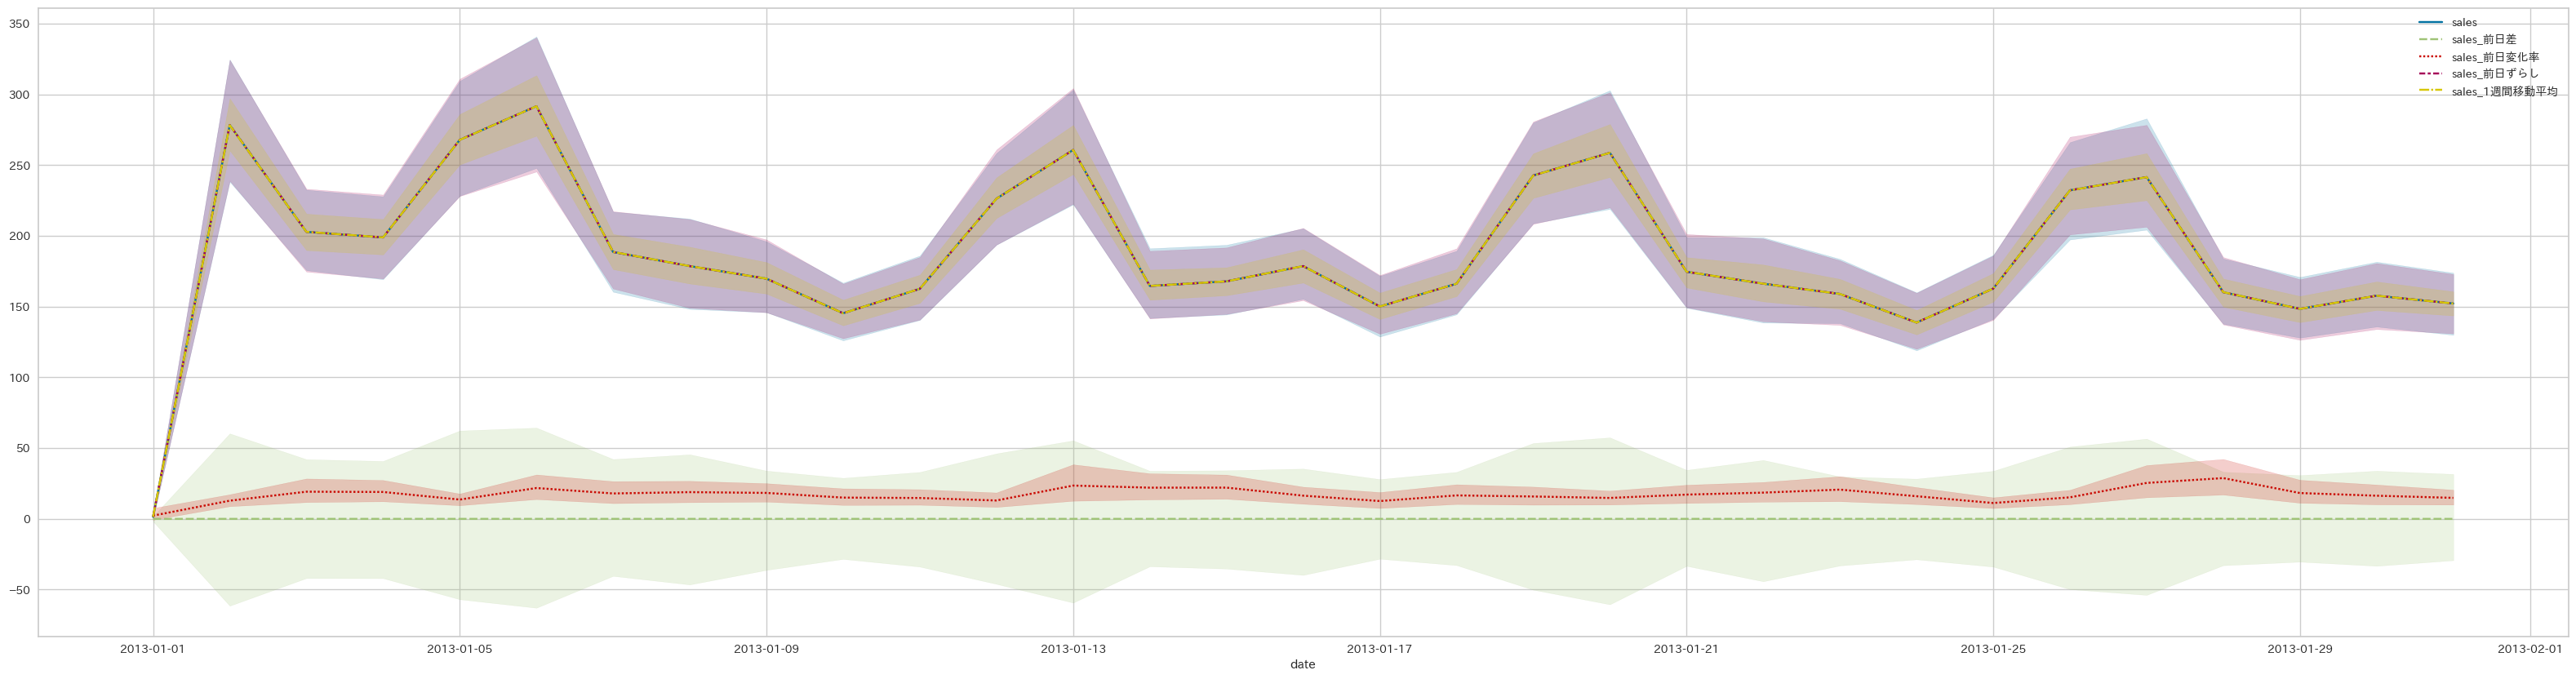

In [35]:
#2013-01を表示 
fig = plt.subplots(figsize=(40,10))
sns.lineplot(data=train_sales_df['2013-01'])

In [36]:
#欠損値の確認
train_df.isnull().sum()

#もし欠損値あったら、1週間前のものを補完するのが適切。

store_nbr      0
family         0
onpromotion    0
sales          0
dtype: int64

#### 自己相関の確認

In [37]:
import statsmodels.api as sm

In [ ]:
#コレログラムで可視化
#何日後との相関が高いのかがわかる。
re = sm.graphics.tsa.plot_acf(train_sales_df['sales'],lags=400)

### 波形分解

In [ ]:
re = sm.tsa.seasonal_decompose(train_sales_df['sales'].values,freg=365).plot()

## まずは前処理なしで、SARIMA,SARIMAXなどを試してみる

## SARIMA(自己回帰、和分、移動平均モデル)  
S(データに周期性) + ARIMA